Quantized Image Saved as: D:\sem 6\DIP\L01 images\octree_K16.png


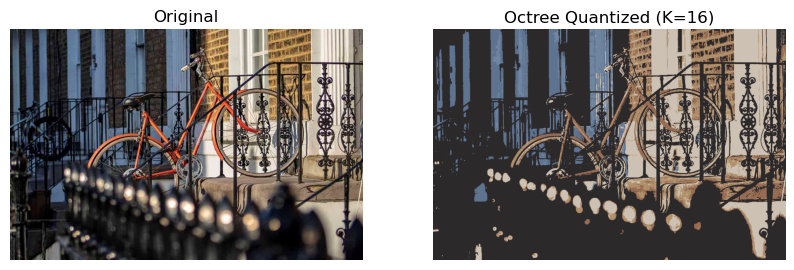

In [1]:
# Octree quantization for ONE value of K (ready to run)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

IMAGE_PATH = r"D:\sem 6\DIP\L01 images\Blur Img 01.png"   # your image
OUTPUT_DIR = os.path.dirname(IMAGE_PATH)

K = 16   # <<< CHANGE THIS IF YOU WANT A DIFFERENT K (e.g., 32 or 8)

# ------------------------------
# Octree implementation
# ------------------------------
class OctreeNode:
    def __init__(self, level, parent=None):
        self.is_leaf = (level >= OctreeQuantizer.MAX_DEPTH)
        self.color_count = 0
        self.red_sum = 0
        self.green_sum = 0
        self.blue_sum = 0
        self.children = [None]*8
        self.parent = parent
        self.level = level
        self.palette_index = None

    def accumulate(self, color):
        r,g,b = color
        self.color_count += 1
        self.red_sum += r
        self.green_sum += g
        self.blue_sum += b

    def get_mean_color(self):
        if self.color_count == 0:
            return (0,0,0)
        return (int(self.red_sum/self.color_count),
                int(self.green_sum/self.color_count),
                int(self.blue_sum/self.color_count))

class OctreeQuantizer:
    MAX_DEPTH = 8

    def __init__(self):
        self.root = OctreeNode(level=0)
        self.reducible = defaultdict(list)
        self.leaf_count = 0

    def _get_child_index(self, color, level):
        shift = 7 - level
        r_bit = (color[0] >> shift) & 1
        g_bit = (color[1] >> shift) & 1
        b_bit = (color[2] >> shift) & 1
        return (r_bit << 2) | (g_bit << 1) | b_bit

    def add_color(self, color):
        node = self.root
        for level in range(OctreeQuantizer.MAX_DEPTH):
            if node.is_leaf:
                break
            idx = self._get_child_index(color, level)
            if node.children[idx] is None:
                child = OctreeNode(level=level+1, parent=node)
                node.children[idx] = child
                if not child.is_leaf:
                    self.reducible[level+1].append(child)
                else:
                    self.leaf_count += 1
                node = child
            else:
                node = node.children[idx]

        if node.is_leaf:
            if node.color_count == 0:
                self.leaf_count += 1
        node.accumulate(color)

    def _reduce_once(self):
        for level in range(OctreeQuantizer.MAX_DEPTH-1, -1, -1):
            if self.reducible.get(level):
                node = self.reducible[level].pop()
                red_sum = green_sum = blue_sum = count = 0

                for i in range(8):
                    child = node.children[i]
                    if child is not None:
                        red_sum += child.red_sum
                        green_sum += child.green_sum
                        blue_sum += child.blue_sum
                        count += child.color_count
                        if child.is_leaf:
                            self.leaf_count -= 1
                        node.children[i] = None

                node.is_leaf = True
                node.red_sum += red_sum
                node.green_sum += green_sum
                node.blue_sum += blue_sum
                node.color_count += count
                self.leaf_count += 1
                return True
        return False

    def reduce_to_k(self, k):
        while self.leaf_count > k:
            if not self._reduce_once():
                break

    def build_palette(self):
        palette = []
        stack = [self.root]

        while stack:
            node = stack.pop()
            if node is None:
                continue
            if node.is_leaf:
                palette.append((node.get_mean_color(), node))
            else:
                for c in node.children:
                    if c is not None:
                        stack.append(c)

        for i, (col, node) in enumerate(palette):
            node.palette_index = i

        return [col for col, node in palette]

    def _find_palette_index(self, color):
        node = self.root
        for level in range(OctreeQuantizer.MAX_DEPTH):
            if node.is_leaf:
                return node.palette_index

            idx = self._get_child_index(color, level)
            if node.children[idx] is None:
                while node is not None and not node.is_leaf:
                    node = node.parent
                if node is None:
                    return 0
                return node.palette_index

            node = node.children[idx]

        return node.palette_index if node else 0

    def quantize_image(self, img_arr, k):
        self.root = OctreeNode(level=0)
        self.reducible = defaultdict(list)
        self.leaf_count = 0

        h,w,_ = img_arr.shape
        for y in range(h):
            for x in range(w):
                self.add_color(tuple(int(v) for v in img_arr[y,x]))

        if self.leaf_count > k:
            self.reduce_to_k(k)

        palette = self.build_palette()
        palette_arr = np.array(palette, dtype=np.uint8)

        out = np.zeros_like(img_arr)
        for y in range(h):
            for x in range(w):
                idx = self._find_palette_index(tuple(int(v) for v in img_arr[y,x]))
                out[y,x] = palette_arr[idx]

        return out, palette_arr

# -----------------------------------------
# Run octree quantization for ONE K value
# -----------------------------------------
img = Image.open(IMAGE_PATH).convert('RGB')
img_arr = np.array(img)

quantizer = OctreeQuantizer()
out_img_arr, palette = quantizer.quantize_image(img_arr, K)

# Save result
output_path = os.path.join(OUTPUT_DIR, f"octree_K{K}.png")
Image.fromarray(out_img_arr).save(output_path)

print("Quantized Image Saved as:", output_path)

# Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_arr)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(out_img_arr)
plt.title(f"Octree Quantized (K={K})")
plt.axis("off")

plt.show()
